# Regridding AMSR2 ASI Sea Ice Concentration

This notebook demonstrates how to reproject and resample AMSR2 Sea Ice Concenration data from the University of Bremen from the [NSIDC Southern Polar Stereographic projection on Hugh's 1980 ellipsoid](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection#anchor-0) to an unprojected latitude-longitude grid on the WGS84 ellipsoid.

We use `rioxarray`, an extension of the `xarray` package, to reproject the dataset.  The data are then plotted using `cartopy` and `matplotlib`.

Using `rioxarray` and `xarray.open_dataset` to open the data file(s) with `decode_coords="all"` automatically sets the Coordinate Reference System (CRS) and Geotransform for the dataset using the `grid_mapping` attribute of the data variable.  The data files need to contain this information in a format that is recognized by `rioxarray`.  Correctly formatted files that follow [CF conventions](http://cfconventions.org/) should be interpretted correctly by `rioxarray`.

If you are using a dataset that does not follow CF conventions, the CRS can be set using the [`write_crs()`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.rioxarray.XRasterBase.write_crs) method.

In [1]:
from pathlib import Path

import numpy as np
import rioxarray
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Data are from https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/s6250/netcdf/
DATAPATH = Path("/media/apbarret/andypbarrett_work/Data/AMSR_Sea_Ice_Conc/asi-AMSR2-s6250-20131104-v5.4.nc")

In [2]:
import cartopy
cartopy.__version__

'0.21.1'

With `rioxarray` loaded, `xarray.open_dataset` can be used to load the data file.  Setting `decode_coords="all"` sets the CRS (coordinate reference system) to the CRS defined in the `grid_mapping` attribute of `ds["z"]`.

In [3]:
ds = xr.open_dataset(DATAPATH, decode_coords="all")
ds

<xarray.Dataset>
Dimensions:              (x: 1264, y: 1328)
Coordinates:
    polar_stereographic  |S1 ...
  * x                    (x) float64 -3.947e+06 -3.941e+06 ... 3.947e+06
  * y                    (y) float64 -3.947e+06 -3.941e+06 ... 4.347e+06
Data variables:
    z                    (y, x) float32 ...
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 19:57:11 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

The dataset CRS can be accessed as follows.

In [4]:
ds.rio.crs

CRS.from_wkt('PROJCS["NSIDC Sea Ice Polar Stereographic South",GEOGCS["Unspecified datum based upon the Hughes 1980 ellipsoid",DATUM["Not_specified_based_on_Hughes_1980_ellipsoid",SPHEROID["Hughes 1980",6378273,298.279411123064,AUTHORITY["EPSG","7058"]],AUTHORITY["EPSG","6054"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4054"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-70],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","3412"]]')

We can also get other information about the dataset such as resolution.

See https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors for more methods.

In [5]:
ds.rio.resolution()

(6250.0, -6250.0)

The data are in a projected coordinate system.  In this case the NSIDC South Polar Stereographic projection.  The x and y coordinates are in meters.  If you want the latitude and longitudes for grid cells, these have to calculated.  This is not absolutely necessessary if you are using "projection-aware" tools like `rioxarray`.  But it can be useful.

There are number of tools available to transform projected coordinates to geographic coordinates (latitude and longitude).

Using NSIDC's `polar_convert` tools

We can make a simple plot just to check that the data look OK.

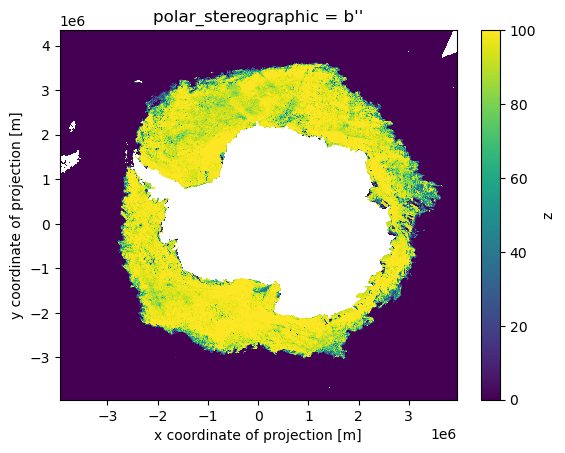

In [6]:
ds.z.plot()

The data can be plotted on a map using the `cartopy` package.  To do this, the map projection (CRS) needs to be defined.  This is done using `cartopy.crs.Stereographic`.  Stereographic projections have three projection parameters; `central_latitude`, `central_longitude`, and `true_scale_latitude` (the latitude at which the scale factor of the projection is 1.).  These can be looked up on https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection#anchor-0.  They can also be accessed directly from the CRS method of the `rioxarray` object.  This is done by returning a python dictionary.

The NSIDC South Polar Stereographic projection used for the dataset is based on the Hugh's 1980 ellipsoid.  This is seen in the SPHEROID definition in the WKT returned by `ds.rio.crs`.  The default ellipsoid for `cartopy` projection definitions is WGS84.  So in addition to defining the Polar Stereographic projecton parameters, the `globe` also needs to be defined using `cartopy.crs.Globe`.  Two parameters are required; semimajor and semiminor axes.  Semiminor axis is calculated from the semimajor axis and inverse flattening from the CRS.  Where semiminor axis ($b$) is:
$$
b = a \times (1 - f)
$$
where $a$ is semimajor axis length and $f$ is flattening.

The extent of the map is set using minimuma and maxima of the x and y coordinate axes.  These give the coordinates of the grid centers so half a grid cell is added or subtracted to get the corners of the grid.

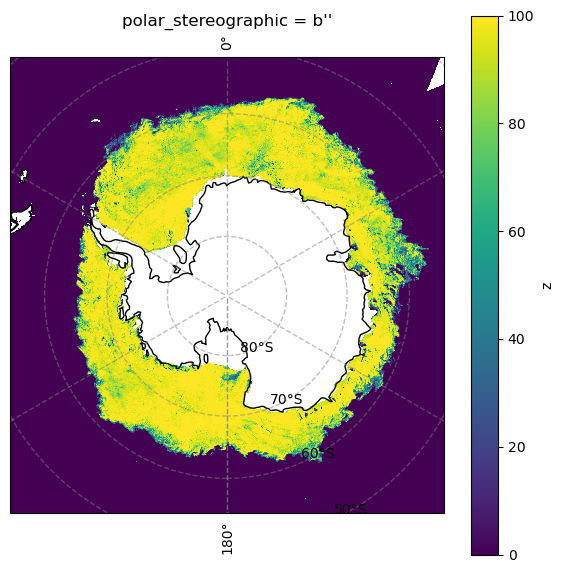

In [7]:
# Define the CRS for Cartopy.  In newer versions of cartopy this can be done by
# ccrs.Projection.from_wkt(ds.rio.crs.to_wkt())
proj_dict = ds.rio.crs.to_dict()
hughs1980 = ccrs.Globe(
    semimajor_axis=proj_dict['a'], 
    semiminor_axis=proj_dict['a']*(1-1/proj_dict['rf'])
) 
south_polar_stereo = ccrs.Stereographic(
    central_latitude=proj_dict['lat_0'], 
    central_longitude=proj_dict['lon_0'], 
    true_scale_latitude=proj_dict['lat_ts'],
    globe=hughs1980
)

# Get extent from dataset
dx, dy = ds.rio.resolution()
extent = [ds.x.min() - dx, ds.x.max() + dx, ds.y.min() + dy, ds.y.max() - dy]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=south_polar_stereo)
ax.set_extent(extent, south_polar_stereo)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

ax.coastlines()
ds.z.plot(ax=ax)

We can focus on the Ross Sea region

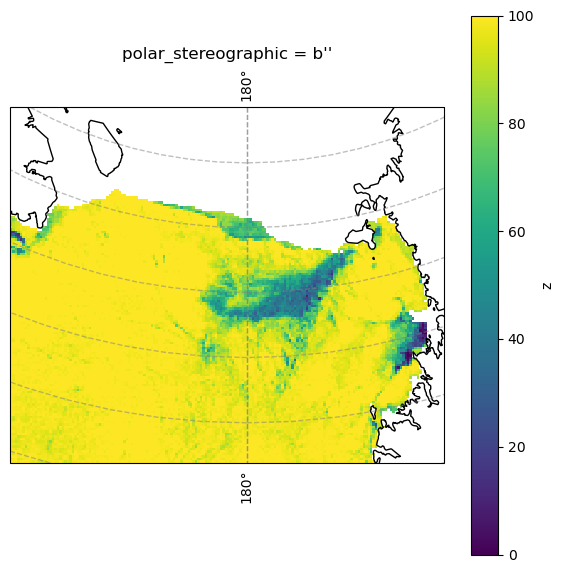

In [8]:
# Get extent from dataset
ross_sea_extent = [-600e3, 500e3, -1900e3, -1000e3]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=south_polar_stereo)
ax.set_extent(ross_sea_extent, south_polar_stereo)

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

ax.coastlines()
ds.z.plot(ax=ax)

In [9]:
ds_ll = ds.rio.reproject("EPSG:4326")

In [10]:
ds_ll

<xarray.Dataset>
Dimensions:              (x: 3724, y: 525)
Coordinates:
  * x                    (x) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y                    (y) float64 -39.31 -39.41 -39.51 ... -89.78 -89.88
    polar_stereographic  int64 0
Data variables:
    z                    (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 19:57:11 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

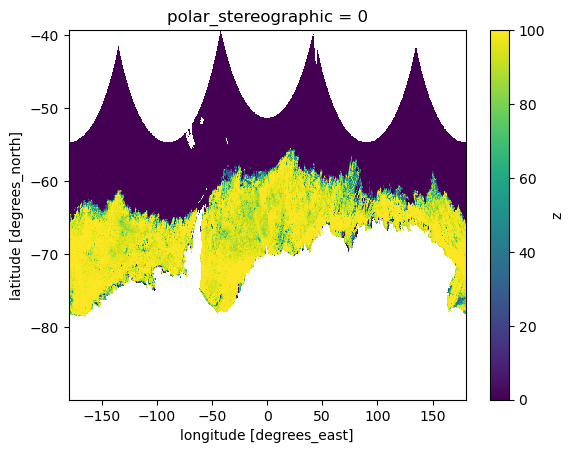

In [11]:
ds_ll.z.plot()

The image appears distorted because it has been reprojected from a stereographic projection.

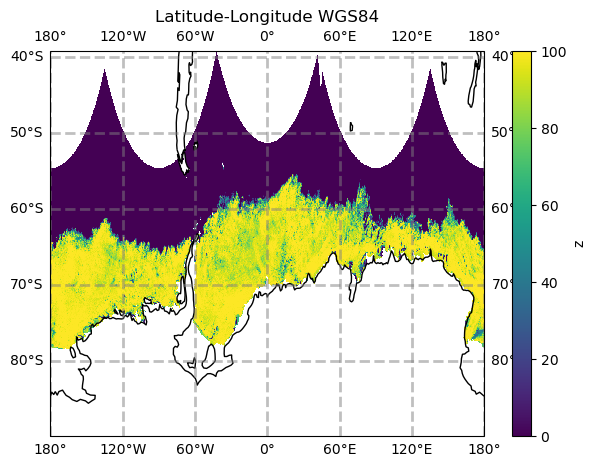

In [12]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.coastlines()
ax.set_aspect('auto')

ds_ll.z.plot(ax=ax)

ax.set_title("Latitude-Longitude WGS84");

Plotting the latitude-longitude grid for the Ross Sea area is problematic because this area straddles the date line (180 E).  Subsetting the latitude-longitude grid for this area is also a problem for the same reason.

If we just want to make a plot to check that the data was regridded correctly, we can plot the reprojected `ds_ll` data on a map in the same South Polar Stereographic projection as the original data.  All we have to do is to pass `matplotlib` the CRS of the `ds_ll` data using the `transform` keyword.

The plot below shows the original data and reprojected data side-by-side.

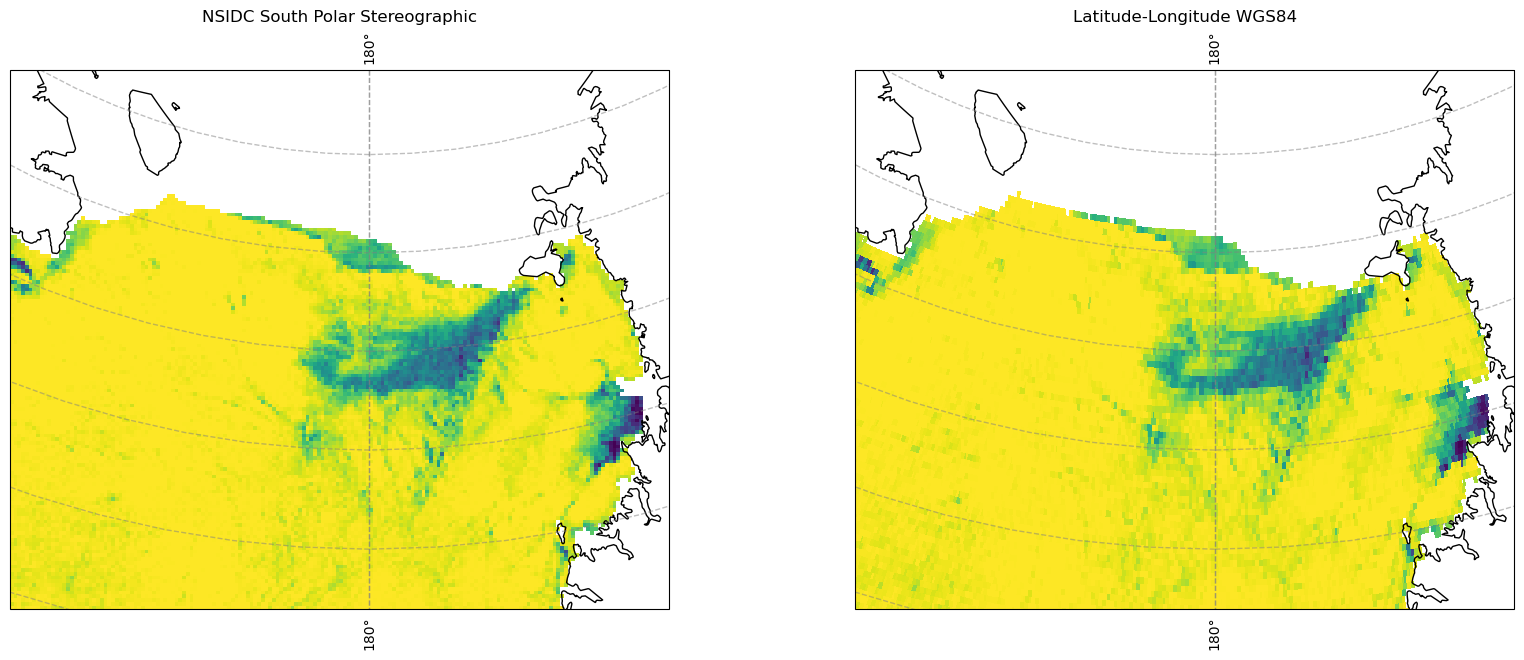

In [14]:
# Get extent from dataset
ross_sea_extent = [-600e3, 500e3, -1900e3, -1000e3]

fig = plt.figure(figsize=(20,7))

# Plot for Polar Stereographic
ax1 = fig.add_subplot(121, projection=south_polar_stereo)
ax1.set_extent(ross_sea_extent, south_polar_stereo)
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines()
ds.z.plot(ax=ax1, add_colorbar=False)
ax1.set_title("NSIDC South Polar Stereographic")

# Plot for WGS84
ax2 = fig.add_subplot(122, projection=south_polar_stereo)
ax2.set_extent(ross_sea_extent, south_polar_stereo)
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines()
ds_ll.z.plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False)
ax2.set_title('Latitude-Longitude WGS84');

## Specifying a different output resolution

In [16]:
print(f"NSIDC South Polar Stereo. Resolution: {ds.rio.resolution()} m")
print(f"WGS84 Resolution {ds_ll.rio.resolution()} degrees")

NSIDC South Polar Stereo. Resolution: (6250.0, -6250.0) m
WGS84 Resolution (0.0966702470461869, -0.09649544008191507) degrees


You can access the resolutions of the grids using `xarray.Dataset.rio.resolution()`.  The original resolution is 6250 m, as expected.  `rioxarray` actually calculates this from the `x` and `y` coordinates.  The resolution of the WGS84 grid is ~0.1 degrees, which is ~5000 m at the equator.  You can specify a different output resolution by setting the `resolution` keyword in the `reproject` method.

In [17]:
ds_ll = ds.rio.reproject("EPSG:4326", resolution=(0.1, 0.1))

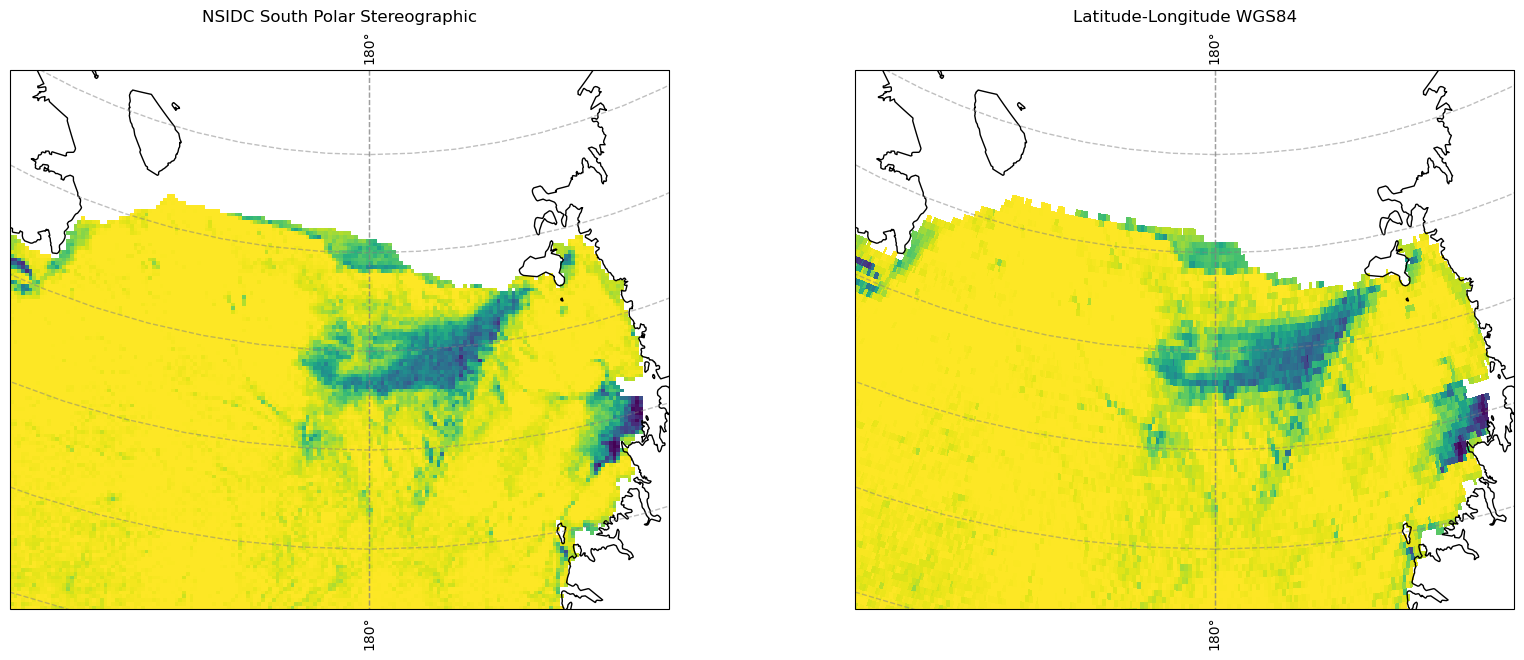

In [18]:
# Get extent from dataset
ross_sea_extent = [-600e3, 500e3, -1900e3, -1000e3]

fig = plt.figure(figsize=(20,7))

# Plot for Polar Stereographic
ax1 = fig.add_subplot(121, projection=south_polar_stereo)
ax1.set_extent(ross_sea_extent, south_polar_stereo)
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax1.coastlines()
ds.z.plot(ax=ax1, add_colorbar=False)
ax1.set_title("NSIDC South Polar Stereographic")

# Plot for WGS84
ax2 = fig.add_subplot(122, projection=south_polar_stereo)
ax2.set_extent(ross_sea_extent, south_polar_stereo)
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.coastlines()
ds_ll.z.plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False)
ax2.set_title('Latitude-Longitude WGS84');

## The Geotransform

_The `transform` is also called the Geotransform and is an Affine matrix that locates the coordinates of each grid cell in the coordinates of the projection.  For the WGS84 latitude-longitude grid, the `transform` relates each grid cell to a latitude and longitude pair by defining the location of the upper-left corner of the grid and the x and y dimensions of each grid cell.

Just calling the `transform` method returns the transform matrix.

In [ ]:
ds_ll.rio.transform()

The first row contains the width of the grid cells in degrees (the units of the CRS), a rotation for the x-axis (zero in this case and in most cases), the x cordinate of the the upper-left corner of the grid (-180 degrees).  The second row contains similar nformation about the y coordinates but in a different order; the rotation of the y-axis (zero), the height of the grid cells, and the y coordinate of the upper-left grid cell.  The height is negative because the origin of the grid is the upper-left corner but the y-axis increases from south to north (bottom to top).

